<a href="https://colab.research.google.com/github/JP109/Custom-Tensorflow/blob/main/Custom_Training_Loop(Tf_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will create a custom training loop for a model classifying Fashion MNIST Dataset

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [8]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

Shuffling and writing examples to ./data/fashion_mnist/3.0.1.incompleteH5LH9N/fashion_mnist-train.tfrecord


Shuffling and writing examples to ./data/fashion_mnist/3.0.1.incompleteH5LH9N/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [10]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [11]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

In [12]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [14]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [15]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

In [16]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

In [17]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

In [18]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.2149: 100%|██████████| 938/938 


 Epoch 0: Train loss: 0.5301  Validation Loss: 0.4637, Train Accuracy: 0.8159, Validation Accuracy 0.8337
Start of epoch 1


Training loss for step 937: 0.3336: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3882  Validation Loss: 0.4269, Train Accuracy: 0.8598, Validation Accuracy 0.8476
Start of epoch 2


Training loss for step 937: 0.3796: 100%|█████████▉| 937/938 


 Epoch 2: Train loss: 0.3504  Validation Loss: 0.3804, Train Accuracy: 0.8727, Validation Accuracy 0.8626
Start of epoch 3


Training loss for step 937: 0.2853: 100%|██████████| 938/938 


 Epoch 3: Train loss: 0.3311  Validation Loss: 0.3977, Train Accuracy: 0.8800, Validation Accuracy 0.8597
Start of epoch 4


Training loss for step 937: 0.3569: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3129  Validation Loss: 0.3916, Train Accuracy: 0.8842, Validation Accuracy 0.8638
Start of epoch 5


Training loss for step 937: 0.1828: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2962  Validation Loss: 0.3601, Train Accuracy: 0.8899, Validation Accuracy 0.8743
Start of epoch 6


Training loss for step 937: 0.2642: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2830  Validation Loss: 0.3709, Train Accuracy: 0.8953, Validation Accuracy 0.8713
Start of epoch 7


Training loss for step 937: 0.3809: 100%|█████████▉| 937/938 


 Epoch 7: Train loss: 0.2723  Validation Loss: 0.3579, Train Accuracy: 0.8983, Validation Accuracy 0.8754
Start of epoch 8


Training loss for step 937: 0.3497: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2667  Validation Loss: 0.3748, Train Accuracy: 0.9012, Validation Accuracy 0.8713
Start of epoch 9


Training loss for step 937: 0.2276: 100%|██████████| 938/938 


 Epoch 9: Train loss: 0.2543  Validation Loss: 0.3590, Train Accuracy: 0.9046, Validation Accuracy 0.8786


In [19]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

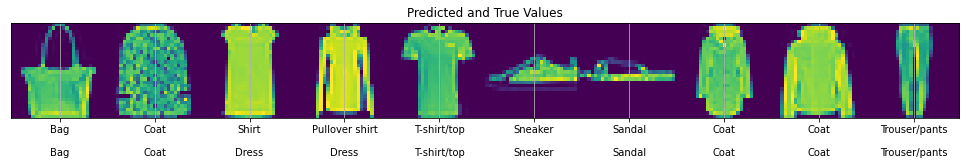

In [20]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)